# Getting Started With Robot Inverse Kinematics (IK)

Welcome to the first guide in the series of getting started with Dr.QP robot Inverse Kinematics (IK).
In this guide, we will cover the basics of IK and how to use it to control a robot.

## What is Inverse Kinematics?
Inverse Kinematics (IK) is a technique used in robotics to determine the joint angles required to achieve a desired end-effector position. It is the process of solving the inverse problem of forward kinematics, which calculates the end-effector position given the joint angles.

## Why is Inverse Kinematics Important?
Inverse Kinematics is important because it allows robots to perform complex movements and tasks. By calculating the joint angles required to reach a specific position, robots can navigate their environment and interact with objects more effectively.

## How to Use Inverse Kinematics
To use Inverse Kinematics, you need to have a model of your robot's kinematics. This model includes the lengths of the robot's links and the joint angles. Once you have this model, you can use it to calculate the joint angles required to achieve a desired end-effector position.

## Setting up the Jupyter notebook

Before we start, lets configure matplotlib to display plots inline:

In [1]:
%matplotlib inline

As well as enable live python modules reloading, so you can change the code in sibling files and see the results immediately without restarting the kernel

In [2]:
# Enable python modules live reloading
%load_ext autoreload
%autoreload 2

In [3]:
# If on Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
  try:
      import point
      import plotting
  except ImportError:
      !git clone --filter=blob:none --no-checkout --depth 1 --sparse https://github.com/Dr-QP/Dr.QP.git --branch=113-scale-up-ik-to-multi-leg-and-giat
      !cd Dr.QP && git sparse-checkout add packages/runtime/drqp_brain/notebooks && git checkout && cd ..
      !mv Dr.QP/packages/runtime/drqp_brain/notebooks/* .
      !mv Dr.QP/* .
      !rm -rf Dr.QP
      %pip install -r requirements.txt

## The robot model

For this tutorial we will use the simplest part of Dr.QP robot - a single leg.

It has a 3 degrees of freedom and consists of 3 links:
 - coxa (hip)
 - femur (thigh)
 - tibia (shin)
 
and 3 joints:
 - alpha (coxa joint, hip joint)
 - beta (femur joint, thigh joint)
 - gamma (tibia joint, shin joint)

Links have only single property - length. They are connected to each other with joints. Joints have only single property - angle.

The diagrams below will make it much more clear, I promise.

The values below are the default parameters for the simulated leg used in this tutorial.

In [4]:
coxa_length = 5
femur_length = 8
tibia_length = 10

alpha = 0 # controls coxa angle, 0 is straight
beta = 0 # controls femur angle, 0 is straight
gamma = 0 # controls tibia angle, 0 is straight

## Forward kinematics

Before we dive into the details of how inverse kinematics works, let's first get familiar with forward kinematics. The forward kinematics of the robotic leg is the process of calculating the position of the foot based on the angles of the joints.

Coxa, femur and tibia are represented with vector that is rotated at its base. Each next link starts at the ened of the previous link.

In [5]:
from point import Point, Line

# unused
def forward_kinematics_rads(coxa_length, femur_length, tibia_length, alpha_rad, beta_rad, gamma_rad, start_height=2, body_length=3):
    start = Point(0, start_height)
    body = start + Point(body_length, 0, f'{alpha_rad=}rads')
    coxa = body + Point(coxa_length, 0, f'{beta_rad=}rads').rotate(alpha_rad)
    femur = coxa + Point(femur_length, 0, f'{gamma_rad=}rads').rotate(beta_rad)
    tibia = femur + Point(tibia_length, 0, 'Foot').rotate(gamma_rad)

    return Line(start, body, 'Body'), Line(body, coxa, 'Coxa'), Line(coxa, femur, 'Femur'), Line(femur, tibia, 'Tibia')


Radians is a natural way to represent angles in most of the math related to robotics, however I find it easier to think in degrees, therefore I will be using degrees in this notebook.

In [6]:
import numpy as np

def forward_kinematics(coxa_length, femur_length, tibia_length, alpha, beta, gamma, start_height=2, body_length=5):
    alpha_rad = np.radians(alpha)
    beta_rad = np.radians(beta) + alpha_rad
    gamma_rad = np.radians(gamma) + beta_rad

    start = Point(0, start_height)
    body = start + Point(body_length, 0, fr'$\alpha$={alpha}°')
    coxa = body + Point(coxa_length, 0, fr'$\beta$={beta}°').rotate(alpha_rad)
    femur = coxa + Point(femur_length, 0, fr'$\gamma$={gamma}°').rotate(beta_rad)
    tibia = femur + Point(tibia_length, 0, 'Foot').rotate(gamma_rad)

    return Line(start, body, 'Body'), Line(body, coxa, 'Coxa'), Line(coxa, femur, 'Femur'), Line(femur, tibia, 'Tibia')


First, lets see how our leg looks in the neutral position. It is a straight line going from start point at (0, 0) and ending with the `Foot`

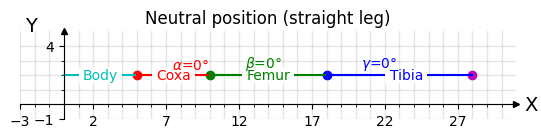

In [7]:
%matplotlib inline
from plotting import plot_leg_with_points

model = forward_kinematics(coxa_length, femur_length, tibia_length, alpha, beta, gamma)

_ = plot_leg_with_points(model, 'Neutral position (straight leg)')

Now lets try changing some angles to see how it behaves. Feel free to experiment with different values.

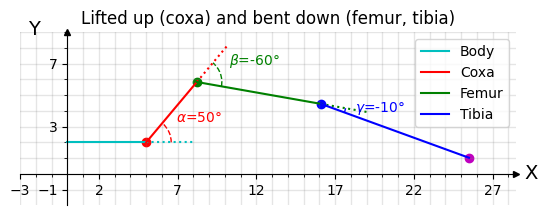

In [8]:
%matplotlib inline

model = forward_kinematics(coxa_length, femur_length, tibia_length, 50, -60, -10)

_ = plot_leg_with_points(model, 'Lifted up (coxa) and bent down (femur, tibia)', link_labels='legend')


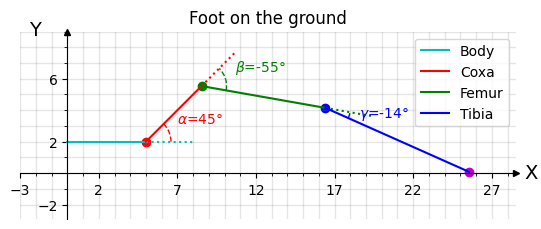

In [9]:
%matplotlib inline

# Lifted up (coxa) and bent down (femur), with foot on the ground (guessed angle)
model = forward_kinematics(coxa_length, femur_length, tibia_length, 45, -55, -14)

_ = plot_leg_with_points(model, 'Foot on the ground', link_labels='legend')

## Exercise 1. Forward kinematics. Find angles at which the leg is on the ground

Its time to have a little fun with our robot.

Using the sliders on the interactive diagram below try to find angles at which the foot is on the ground.

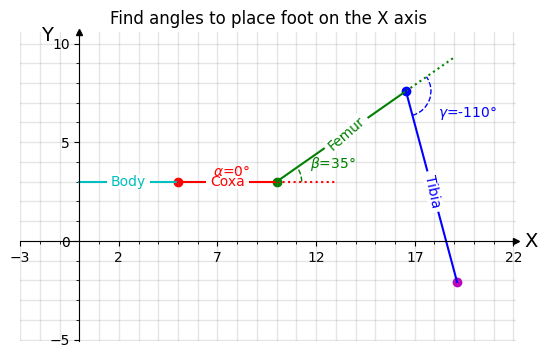

In [10]:
from plotting import plot_leg_update_lines
from ipywidgets import interact
import matplotlib


# To switch to interactive mode:
#  1. Set is_interactive to True
#  2. Restart kernel and run all the cells above
# DO NOT RUN THE CELLS BELOW, matplotlib's widget backend has to be the last magic executed to use interactive backend
is_interactive = False

matplotlib.use('widget' if is_interactive else 'inline')

start_height = 3
alpha = 0
beta = 35
gamma = -110
model = forward_kinematics(
    coxa_length, femur_length, tibia_length, alpha, beta, gamma, start_height=start_height
)
fig, _, lines, joints = plot_leg_with_points(
    model,
    'Find angles to place foot on the X axis',
    # no_joint_labels=is_interactive,
    # no_link_labels=is_interactive,
    link_labels='legend' if is_interactive else 'inline',
    joint_labels='points' if is_interactive else 'annotated',
)


def animate(alpha=alpha, beta=beta, gamma=gamma):
    model = forward_kinematics(
        coxa_length, femur_length, tibia_length, alpha, beta, gamma, start_height=start_height
    )
    plot_leg_update_lines(model, lines, joints)
    fig.canvas.draw_idle()


if is_interactive:
    interact(animate, alpha=(-180, 180, 0.1), beta=(-180, 180, 0.1), gamma=(-180, 180, 0.1))


In [11]:
if is_interactive:
    raise Exception("Stopping here to avoid breaking interactive mode. Set is_interactive to False in the cell above and execute it and all below.")

That was a fun little exercise, but it takes some effort to find just the right angle, and you might have noticed that there are more than one solution to it. 

The problem of having more than one solution is known as over-actuation. It happens for our robotic leg because there are 3 joints in the same plain, giving leg ability of reaching desired goal using various combinations of joint angles. Essentially if links create a polygon with more than 3 sides (more than triangle), then there are multiple solutions.

However, it is not an issue in the real Dr.QP hexapod robot as coxa joint is in the different plain in 3D space. Therefore we are not going to expand on this topic further right now and will keep coxa joint angle (alpha) fixed at 0 degree. This will prevent over-actuation and simplify the problem.

Additionally we are going to work with projections or slices of 3D space to a 2D space from here on. ROS is using right hand side coordinates system, Z is up, X is forward, Y is left. We are going to work with XY plane (top view) and XZ plane (side view) for the rest of the notebook. THe X'Z plane is the plane of the leg, it will be explained more in the following chapter.

There are various ways to solve inverse kinematics problem. We are going to use the fairly basic one, which is based on trigonometry, since it is the most straightforward way to solve it for Dr.QP legs.

## Solving inverse kinematics using trigonometry

The following 2 chapters will cover the math behind solving inverse kinematics for a 3DOF leg. Coxa IK and Femur/Tibia IK are solved separately as they lie in different planes.

This diagram should give you an idea of what we are trying to solve:

<img src="https://github.com/user-attachments/assets/e6447032-cd1a-4f5b-b756-689c733b8389" />

`TODO: Update diagram with the one from Dr.QP leg and names of angles and planes matching this notebook`

In [12]:
# Custom lengths for the IK examples
coxa_len = 5
femur_len = 10
tibia_len = 14

### Coxa Inverse Kinematics

Coxa joint (alpha) is located in the XY plane (aka top view), X being forward and Y being left.

IK problem is to find angle alpha that will align leg with a given target point. Even if point is 3D (X, Y, Z), for this part of the problem only (X, Y) are considered.

Below you can find a view of the leg in XY plane 

<Axes: title={'center': 'XY plane (top view)'}, xlabel='X', ylabel='Y'>

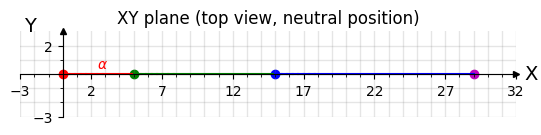

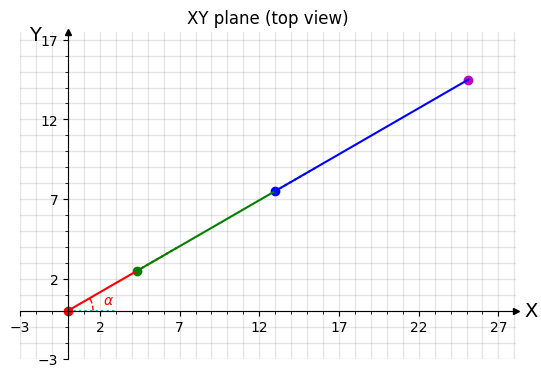

In [13]:
def forward_kinematics_xy(coxa_length, femur_length, tibia_length, alpha, show_alpha_value=False):
    body_rad = np.radians(0)
    alpha_rad = body_rad + np.radians(alpha)
    start = Point(0, 0)
    body = start + Point(0.001, 0, fr'$\alpha$={alpha:.2f}°' if show_alpha_value else r'$\alpha$').rotate(body_rad)
    coxa = body + Point(coxa_length, 0).rotate(alpha_rad)
    femur = coxa + Point(femur_length, 0).rotate(alpha_rad)
    tibia = femur + Point(tibia_length, 0, 'Foot').rotate(alpha_rad)

    return Line(start, body, 'Body'), Line(body, coxa, 'Coxa'), Line(coxa, femur, 'Femur'), Line(femur, tibia, 'Tibia')


def plot_leg_with_points_xy(model: list[Line], title: str):
    _, ax, _, _ = plot_leg_with_points(model, title, link_labels='none', x_label='X', y_label='Y')
    return ax


model = forward_kinematics_xy(coxa_len, femur_len, tibia_len, 0)
plot_leg_with_points_xy(model, 'XY plane (top view, neutral position)')


model = forward_kinematics_xy(coxa_len, femur_len, tibia_len, 30)
plot_leg_with_points_xy(model, 'XY plane (top view)')


Finding angle $\alpha$ is a trivial problem, since we are dealing with a right triangle.

<Axes: title={'center': 'Coxa (alpha) IK'}, xlabel='X', ylabel='Y'>

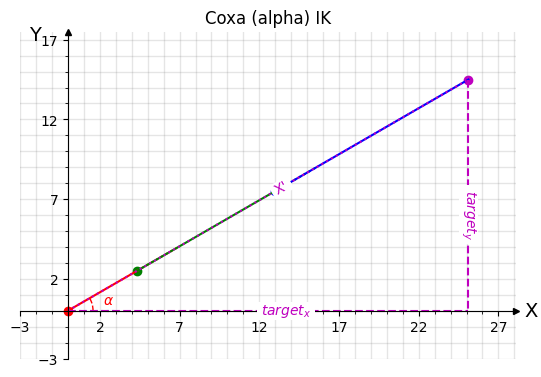

In [14]:
from inline_labels import add_inline_labels


def plot_leg_with_points_xy_ik(model: list[Line], title: str):
    ax = plot_leg_with_points_xy(model, title)
    start = model[0].start
    foot = model[-1].end
    x_projection = Point(foot.x, 0)
    ax.plot(*zip(foot, x_projection), 'm--', label=r'$target_y$')
    ax.plot(*zip(start, x_projection), 'm--', label=r'$target_x$')
    ax.plot(*zip(start, foot), 'm:', label="X'")
    add_inline_labels(ax, with_overall_progress=False, fontsize='medium')
    ax.legend().remove()
    return ax

model = forward_kinematics_xy(coxa_len, femur_len, tibia_len, 30)
plot_leg_with_points_xy_ik(model, 'Coxa (alpha) IK')

Our right triangle is formed by lines $target_y$ and $target_x$ and hypotenuse $X'$ which is the leg itself. Therefore a simple $arctan$ will give us the angle:

$\Large \alpha = arctan(\frac{target_y}{target_x})$ or in python: `alpha = math.atan2(foot_target.y, foot_target.x)`

The second computation we need to make is the length of the hypotenuse $X'$ that will be used in the IK for the X'Z plane. This distance will be location of the foot target in $X'$ direction.

$\Large X' = \sqrt{target_x^2 + target_y^2}$ or in python: `X_tick = math.hypot(foot_target.x, foot_target.y)`

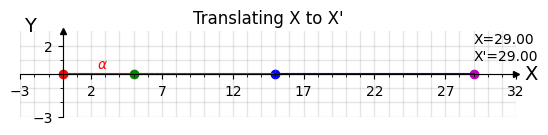

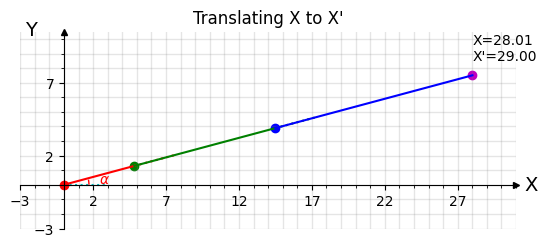

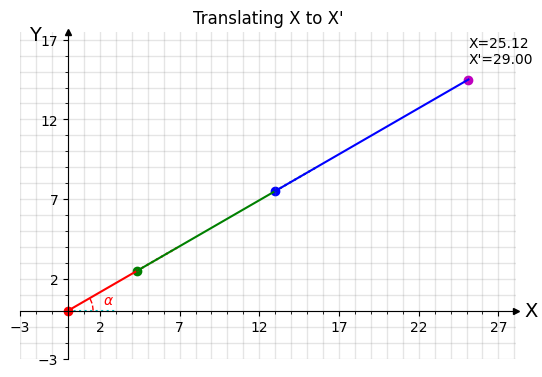

In [15]:
import math

def plot_xtick(alpha):
  model = forward_kinematics_xy(coxa_len, femur_len, tibia_len, alpha)
  ax = plot_leg_with_points_xy(model, "Translating X to X\'")

  foot = model[-1].end
  ax.text(foot.x, foot.y + 1, f"X={foot.x:.2f}\nX'={math.hypot(foot.x, foot.y):.2f}")

plot_xtick(0)
plot_xtick(15)
plot_xtick(30)

Putting all of this in code will look as follows

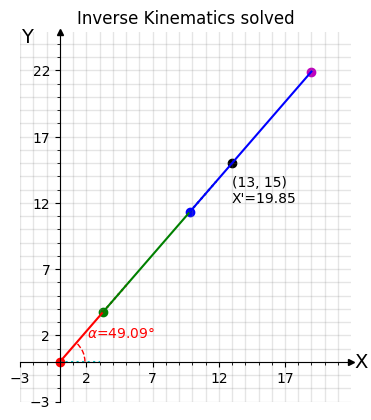

In [16]:
from point import Point3D

def coxa_ik(foot_target):
    alpha = math.degrees(math.atan2(foot_target.y, foot_target.x))
    X_tick = math.hypot(foot_target.x, foot_target.y)
    return alpha, X_tick

def plot_leg_ik_xy(foot_target: Point, plot_title='Inverse Kinematics solved'):
    alpha, X_tick = coxa_ik(foot_target)

    model = forward_kinematics_xy(coxa_len, femur_len, tibia_len, alpha, show_alpha_value=True)

    ax = plot_leg_with_points_xy(model, plot_title)

    ax.scatter(foot_target.x, foot_target.y, color='k', label='Foot target')
    ax.text(foot_target.x, foot_target.y - 3, f"({foot_target.x}, {foot_target.y})\nX'={X_tick:.2f}")
    ax.legend().remove()

foot_target_3d = Point3D(13, 15, -6)

plot_leg_ik_xy(foot_target_3d.xy)

As you can see on the diagram above, coxa IK was solved correctly and leg is now aligned with the target foot position. However leg's foot is not at the target foot position. That will be solved by femur and tibia IK described below.

## Femur and Tibia Inverse Kinematics in X'Z Plane

Inverse Kinematics for Femur and Tibia is a bit more involved than for the Coxa. Let's start by looking at diagram below.

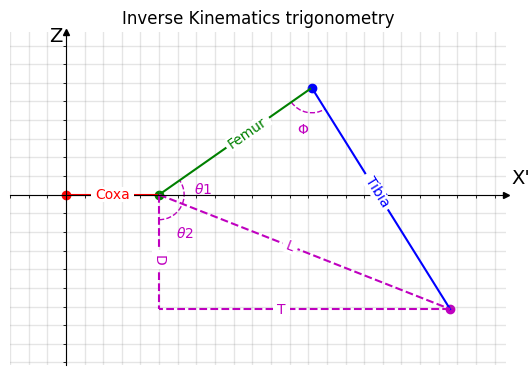

In [17]:
%matplotlib inline

from plotting import plot_ik_lines

alpha = 0
beta = 35
gamma = -93

model = forward_kinematics(
    coxa_len,
    femur_len,
    tibia_len,
    alpha,
    beta,
    gamma,
    # Inverse kinematic is defined in terms of leg coordinate frame, so body length and start_z are 0
    start_height=0,
    body_length=0,
)

fig, ax, _, _ = plot_leg_with_points(
    model,
    'Inverse Kinematics trigonometry',
    joint_labels='points',
    link_labels='label',
    no_cartesian_ticks=True,
    x_label="X'",
    y_label='Z',
)

body, coxa, femur, tibia = model

plot_ik_lines(ax, femur, tibia)


As you can see on the diagram above, there are 2 triangles formed by leg links and additional lines `D`, `T` and `L`. 

Angles $\theta1$, $\theta2$, $\Phi$ are the angles we need to find. They will allow us to compute $\beta$ and $\gamma$.

`D` - is simple, it is the foot's target Z coordinate, negated.

`T` is fairly simple as well, it is target X' coordinate in leg coordinate frame minus coxa length.

`L` - is hypotenuse of the triangle formed by `D` and `T` which can be computed using Pythagorean theorem: $L = \sqrt{D^2 + T^2}$ (or `L = math.hypot(D, T)` in python)

Since `L`, `D`, `T` form a square triangle, $\theta2$ can be computed using trigonometry: $\theta2 = \arctan(\frac{T}{D})$ (or `theta2 = math.atan2(T, D)` in python)

---

For $\theta1$ and $\Phi$ we need to use [law of cosines](https://www.geeksforgeeks.org/law-of-cosine/):

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20240607181448/Law-of-Cosines-copy.webp" width="500">

Which can be rewritten to compute angles as:

$\Large \cos A = (\frac{b^2 + c^2 – a^2}{2bc})$

$\Large \cos B = (\frac{a^2 + c^2 – b^2}{2ac})$


In our case:

$a = L$

$b = tibia$

$c = femur$

angle $A = \Phi$

angle $B = \theta1$

---


Therefore:

$\Large \theta1 = \arccos(\frac{L^2 + femur^2 - tibia^2}{2 * L * femur})$

or in python `theta1 = math.acos((L**2 + femur**2 - tibia**2) / (2 * L * femur))`

Similarly $\Large \Phi = \arccos(\frac{tibia^2 + femur^2 - L^2}{2 * tibia * femur})$

or in python `phi = math.acos((tibia**2 + femur**2 - L**2) / (2 * tibia * femur))`

What is left is to compute $\beta$ and $\gamma$ using the following formulas: 

$\beta = \theta1 + \theta2 - 90$ (offset by 90 degrees to align with leg coordinate frame, see diagram below of a straight leg)

$\gamma = \Phi - 180$



And that is all, lets put it all together:

theta1=59.92815342525586
theta2=67.99854209156905
phi=81.89132152492535

beta=37.92669551682491
gamma=-98.10867847507465


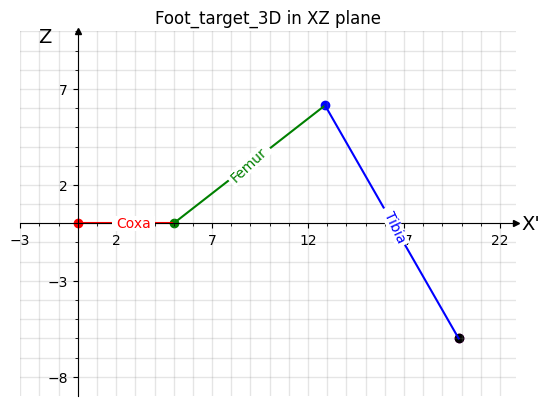

In [18]:
%matplotlib inline

import math

def inverse_kinematics_xz(coxa, femur, tibia, foot_target, verbose=False):
    """
    XZ axis Inverse kinematics solver for 3DOF leg.

    Math as described above
    """
    D = -foot_target.y
    T = foot_target.x - coxa
    L = math.hypot(D, T)

    theta1 = math.degrees(math.acos((L**2 + femur**2 - tibia**2) / (2 * L * femur)))
    theta2 = math.degrees(math.atan2(T, D))
    phi = math.degrees(math.acos((tibia**2 + femur**2 - L**2) / (2 * tibia * femur)))

    beta = (theta1 + theta2) - 90
    gamma = phi - 180
    if verbose:
        print(f'{theta1=}\n{theta2=}\n{phi=}\n\n{beta=}\n{gamma=}')
    return beta, gamma

def solve_and_plot_at_target_xz(
    foot_target: Point, plot_title='Inverse Kinematics solved', verbose=False
):

    beta, gamma = inverse_kinematics_xz(coxa_len, femur_len, tibia_len, foot_target, verbose=verbose)

    model = forward_kinematics(
        coxa_len,
        femur_len,
        tibia_len,
        alpha,
        beta,
        gamma,
        # Inverse kinematic is defined in terms of leg coordinate frame, so body length and start_z are 0
        start_height=0,
        body_length=0,
    )

    fig, ax, _, _ = plot_leg_with_points(
        model,
        plot_title,
        joint_labels='points',
        x_label="X'",
        y_label='Z',
    )

    ax.scatter(foot_target.x, foot_target.y, color='k', label='Foot target')
    ax.legend().remove()
    return beta, gamma


alpha_ik, X_tick = coxa_ik(foot_target_3d.xy)
beta_ik, gamma_ik = solve_and_plot_at_target_xz(
    Point(X_tick, foot_target_3d.z), 'Foot_target_3D in XZ plane', verbose=True
)


And that is all. We have solved inverse kinematics for a 3DOF leg.

In [19]:
print(f'alpha = {alpha_ik:.2f}')
print(f'beta = {beta_ik:.2f}')
print(f'gamma = {gamma_ik:.2f}')

alpha = 49.09
beta = 37.93
gamma = -98.11


To understand where the offset values for beta and gamma in the computation above are coming from, let's plot straight leg and see what theta and phi are.

theta1=0.0
theta2=90.0
phi=180.0

beta=0.0
gamma=0.0


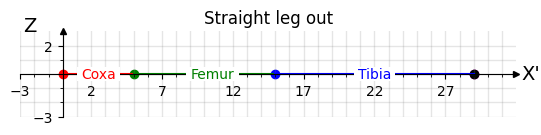

In [20]:
_ = solve_and_plot_at_target_xz(Point(coxa_len + femur_len + tibia_len, 0), "Straight leg out", verbose=True)

Now once we have the solution, let's play with it a little bit and solve for various target points.
If math is working correctly, foot (magenta dot) should always overlap with the target (black dot).

theta1=56.45772587043364
theta2=111.47158023539903
phi=87.0052800205357

beta=77.92930610583267
gamma=-92.9947199794643


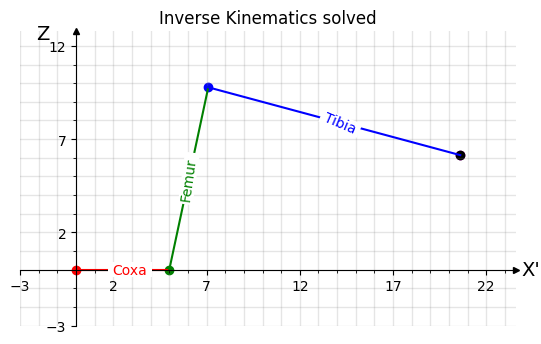

In [21]:
_ = solve_and_plot_at_target_xz(Point(20.61, 6.14), verbose=True)

theta1=88.85400800161142
theta2=90.0
phi=45.5729959991943

beta=88.85400800161142
gamma=-134.4270040008057


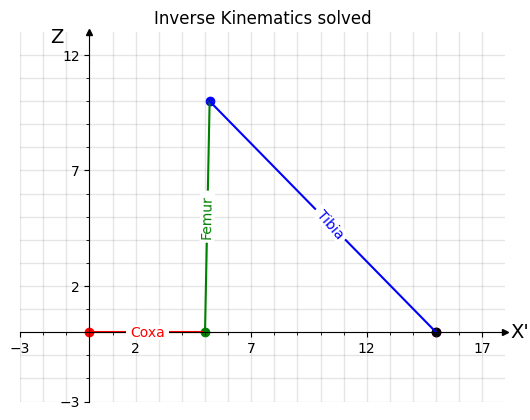

In [22]:
_ = solve_and_plot_at_target_xz(Point(15, 0), verbose=True)

### Putting it all together

In [23]:
def inverse_kinematics(coxa, femur, tibia, foot_target: Point3D):
    alpha, X_tick = coxa_ik(foot_target.xy)
    beta, gamma = inverse_kinematics_xz(coxa, femur, tibia, Point(X_tick, foot_target.z))
    return alpha, beta, gamma

### The classic IK test - drawing a circle

The classic IK test is to draw a circle with the foot in each coordinate plane. Since we are using projects, let's limit it to the XZ plane.

In [32]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 72
plt.ioff()

steps = 32
x = 15.
y = 0.0
z = -1.
scalar = 2

sequence_xz_little_circle = [
    # x, y, z
    Point3D(x + math.sin(i) * scalar, y, z - math.cos(i) * scalar, f'xz-circle step {i}')
    for i in np.linspace(0, np.pi * 2, steps)
]
total_targets = len(sequence_xz_little_circle)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

solved_foot = []
solved_model = []
for target in sequence_xz_little_circle:
    alpha, beta, gamma = inverse_kinematics(coxa_len, femur_len, tibia_len, target)
    model = forward_kinematics(
        coxa_len,
        femur_len,
        tibia_len,
        alpha,
        beta,
        gamma,
        # Inverse kinematic is defined in terms of leg coordinate frame, so body length and start_z are 0
        start_height=0,
        body_length=0,
    )
    foot = model[-1].end
    solved_foot.append(foot)
    solved_model.append(model)




In [33]:

model = solved_model[0]

fig, ax, lines, joints = plot_leg_with_points(
    model,
    'IK Circle',
    link_labels='none',
    joint_labels='points',
)

def animate(frame):
    even = not frame % 2
    if even:
      frame = frame // 2
      target = sequence_xz_little_circle[frame]
      ax.scatter(target.x, target.z, color='k', zorder=-100)
    else:
      frame = frame // 2
      model = solved_model[frame]
      plot_leg_update_lines(model, lines, joints)
      foot = solved_foot[frame]
      ax.scatter(foot.x, foot.y, color='m', alpha=0.5, zorder=100)

FuncAnimation(fig, animate, frames=total_targets * 2, interval=50)
